### Importing Libraries

In [411]:
# Data manipulation and analysis
import pandas as pd
import numpy as np
from scipy import stats  # for statistical functions and outlier detection
import random
from pathlib import Path
from math import ceil

# Feature analysis and selection
from sklearn.feature_selection import SelectKBest, f_regression  # automated feature selection
from scipy.stats import skew, kurtosis  # for skewness and kurtosis analysis

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning models
from sklearn.linear_model import LinearRegression, Ridge, ElasticNet  # ElasticNet for flexible regularization
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, VotingRegressor, StackingRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error  # Additional evaluation metrics
from sklearn.model_selection import KFold
from catboost import CatBoostRegressor, Pool
from xgboost import XGBRegressor
import lightgbm as lgb
from lightgbm import LGBMRegressor

# Data Preprocessing
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

### Creating Configuration Class

In [412]:
class CFG:
    # Paths
    train_path = Path('../data/external/train.csv')
    test_path = Path('../data/external/test.csv')
    subm_path = Path('../data/external/sample_submission.csv')
    
    # Data
    train_df = pd.read_csv(str(train_path))
    test_df = pd.read_csv(str(test_path))
    train_df.name = 'train_df'
    test_df.name = 'test_df'
    
    # Other configurations
    color = '#F08000'
    background_color = '#262626'
    font_color = '#ffffff'
    point_color = '#FF5733'
    
    margin = dict(l=90, r=90, t=90, b=90)
    height = 900
    point_size = 50

    # Model weights and early stopping
    lgb_weight = 0.20
    ctb_weight = 0.20
    xgb_weight = 0.20
    ridge_weight = 0.20
    rfr_weight = 0.20
    early_stop = 50
    n_splits = 15

    # Parameters for models
    lgb_params = {
        'objective': 'regression',
        'min_child_samples': 24,
        'num_iterations': 4000,
        'learning_rate': 0.03,
        'extra_trees': True,
        'reg_lambda': 0.8,
        'reg_alpha': 0.08,
        'num_leaves': 64,
        'metric': 'rmse',
        'device': 'cpu',
        'max_bin': 128,
        'max_depth': 4,
        'verbose': -1,
        'seed': 42
    }
    
    ctb_params = {
        'grow_policy': 'Depthwise',
        'loss_function': 'RMSE',
        'min_child_samples': 4,
        'learning_rate': 0.03,
        'random_state': 42,
        'task_type': 'CPU',
        'reg_lambda': 0.8,
        'num_trees': 4000,
        'depth': 4
    }
    
    xgb_params = {
        'objective': 'reg:squarederror',
        'learning_rate': 0.03,
        'max_depth': 4,
        'n_estimators': 4000,
        'reg_lambda': 0.8,
        'reg_alpha': 0.08,
        'subsample': 0.8,
        'colsample_bytree': 0.8,
        'seed': 42,
        'verbosity': 0
    }
    
    ridge_params = {
        'alpha': 1.0,  
        'solver': 'auto', 
        'random_state': 42
    }
    
    rfr_params = {
        'n_estimators': 1000,
        'max_depth': 10,
        'min_samples_split': 2,
        'min_samples_leaf': 1,
        'max_features': 'auto',
        'bootstrap': True,
        'random_state': 42,
        'n_jobs': -1 
    }


### Define Numerical and Categorical Columns

In [413]:
numeric_cols = CFG.train_df.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = CFG.train_df.select_dtypes(include=['object']).columns

print(numeric_cols)
print(categorical_cols)

Index(['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual',
       'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd',
       'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF',
       'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea',
       'MiscVal', 'MoSold', 'YrSold', 'SalePrice'],
      dtype='object')
Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', '

## Outlier Detection and Removal

### Select Columns for Outlier Removal

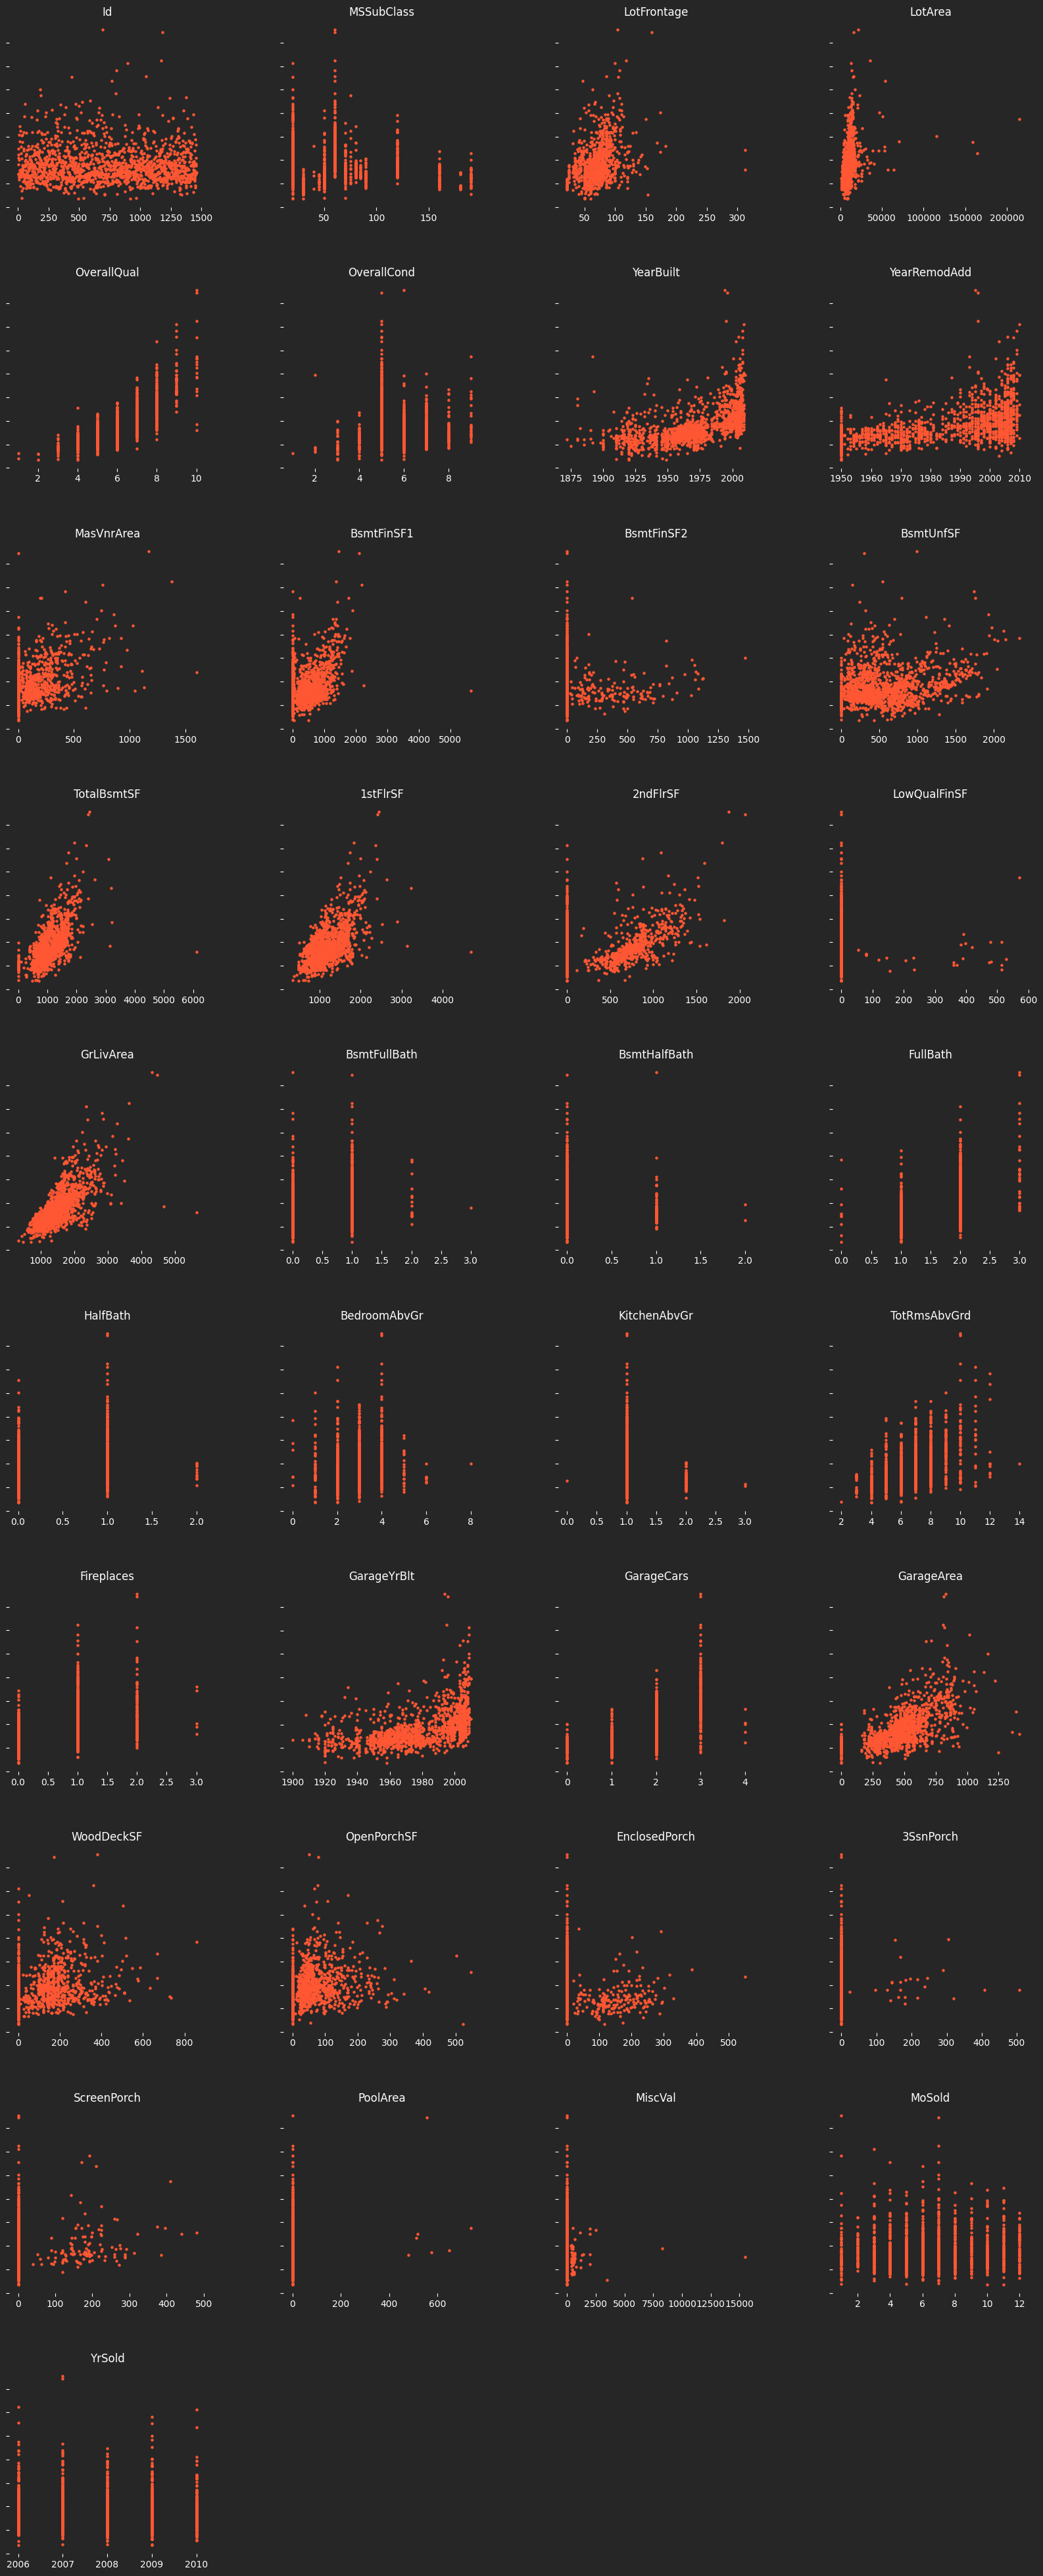

In [414]:
# Define the target column and select numeric features only, excluding the target
target_column = 'SalePrice'
feature_columns = [col for col in numeric_cols if col != target_column]

# Determine the number of rows needed for a 4-column layout
num_columns = 4
num_rows = ceil(len(feature_columns) / num_columns)

# Set up the figure and axes
fig, axes = plt.subplots(num_rows, num_columns, figsize=(20, num_rows * 5), facecolor=CFG.background_color)
fig.subplots_adjust(hspace=0.4, wspace=0.4)

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Plot each feature against SalePrice
for i, feature in enumerate(feature_columns):
    ax = axes[i]
    ax.set_facecolor(CFG.background_color)  # Set background color of each plot
    ax.scatter(CFG.train_df[feature], CFG.train_df[target_column], s=5, color=CFG.point_color)
    ax.set_title(feature, color=CFG.font_color)  # Title is now only the feature name
    
    # Remove x-axis label (keep tick values)
    ax.set_xlabel('')  # Remove x-axis label name only

    # Remove the border
    for spine in ax.spines.values():
        spine.set_visible(False)

    # Apply font color to tick labels on both axes
    ax.tick_params(axis='x', colors=CFG.font_color)  # Keep x-axis tick values in font color
    ax.tick_params(axis='y', colors=CFG.font_color, labelleft=False)  # Remove y-axis labels

# Hide any unused axes if the number of plots is less than the grid
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.show()

In [415]:
without_outliers = ['Id',
                    'MSSubClass',
                    'OverallQual',
                    'OverallCond',
                    'YearBuilt',
                    'YearRemodAdd',
                    'BsmtUnfSF',
                    'LowQualFinSF',
                    'BsmtFullBath',
                    'BsmtHalfBath',
                    'FullBath',
                    'HalfBath',
                    'TotRmsAbvGrd',
                    'Fireplaces',
                    'GarageYrBlt',
                    'GarageCars',
                    'GarageArea',
                    'MoSold',
                    'YrSold']

with_outliers = [col for col in numeric_cols if col not in without_outliers and col != 'SalePrice']

print(with_outliers)

['LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'BedroomAbvGr', 'KitchenAbvGr', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal']


### Remove Outliers Using Z-score Method

In [416]:
def remove_outliers_zscore(df, columns, threshold):
    keep_rows = pd.Series([True] * len(df))
    
    for col in columns:  
        col_z_scores = (df[col] - df[col].mean()) / df[col].std()  # Standardize the column
        keep_rows &= (col_z_scores.abs() < threshold)  # Mark rows that meet the threshold for this column
    
    df_zscore_cleaned = df[keep_rows]  # Apply mask to the DataFrame
    
    print(f"Removed {len(df) - len(df_zscore_cleaned)} outliers based on Z-score threshold of {threshold}")
    return df_zscore_cleaned

train_df_outlier_cleaned = remove_outliers_zscore(CFG.train_df, with_outliers, 4.5)
train_df_outlier_cleaned.name = 'train_df_outlier_cleaned'

Removed 344 outliers based on Z-score threshold of 4.5


### Visualize Changes

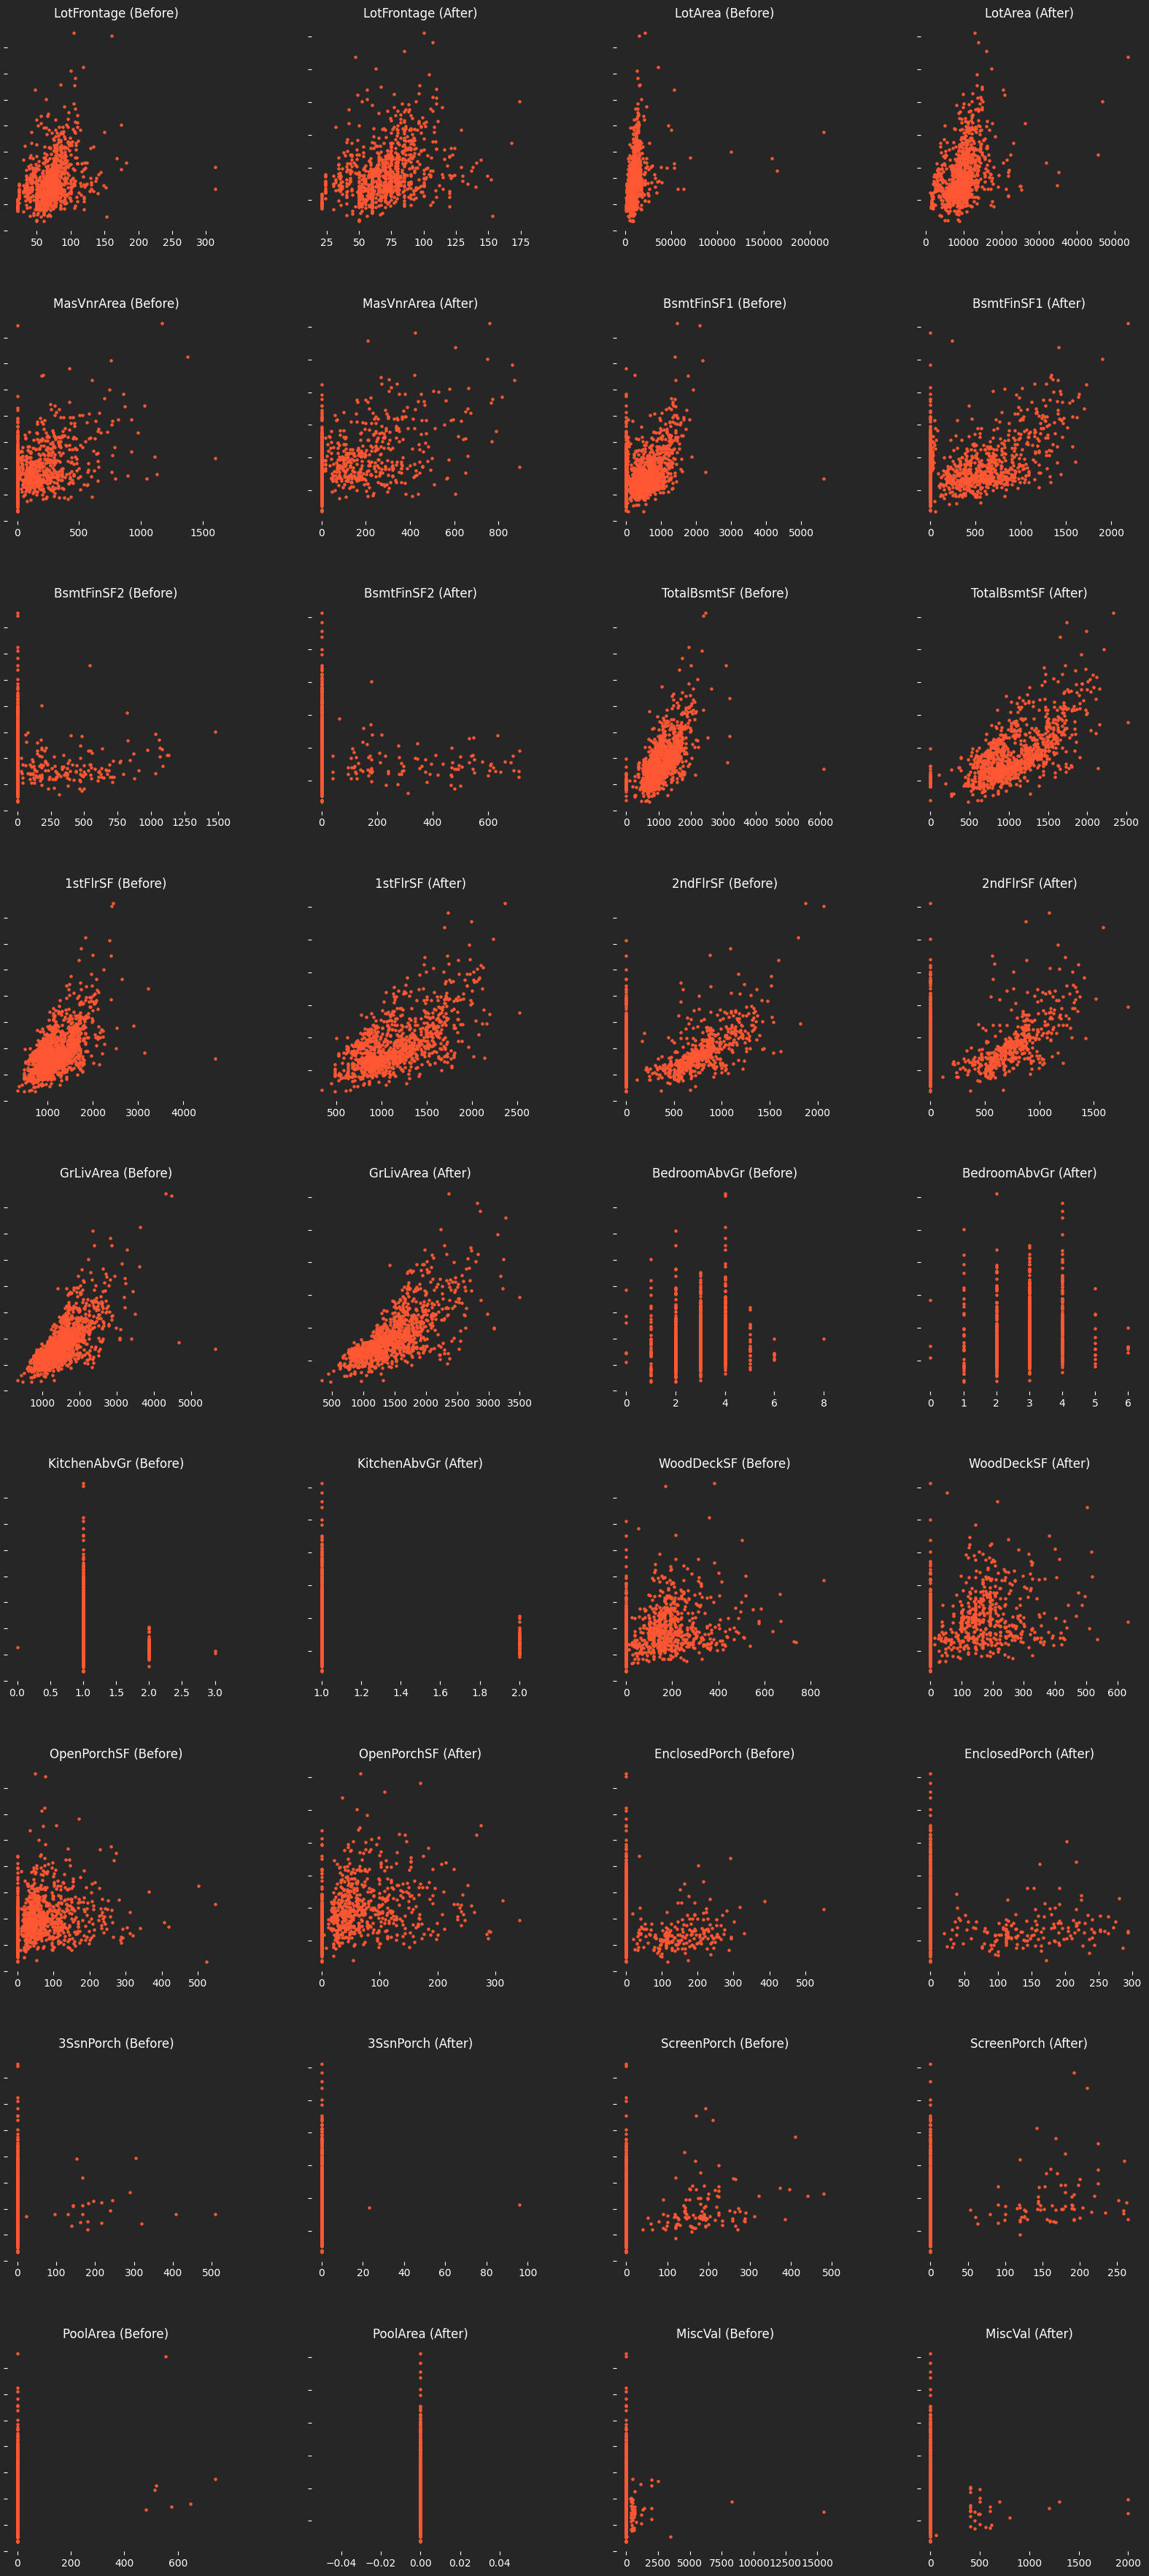

In [417]:
# Number of columns for "before and after" plots
num_features = len(with_outliers)
num_columns = 4  # Four plots per row (two features with "before" and "after" per row)
num_rows = ceil(num_features * 2 / num_columns)  # Each feature takes two plots (before and after)

# Set up the figure with specified background color
fig, axes = plt.subplots(num_rows, num_columns, figsize=(20, num_rows * 5), facecolor=CFG.background_color)
fig.subplots_adjust(hspace=0.4, wspace=0.4)

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Plot each feature in `with_outliers` with before and after outlier removal
for i, feature in enumerate(with_outliers):
    # Plot the "before" scatter plot
    ax_before = axes[2 * i]
    ax_before.set_facecolor(CFG.background_color)
    ax_before.scatter(CFG.train_df[feature], CFG.train_df[target_column], s=5, color=CFG.point_color)
    ax_before.set_title(f"{feature} (Before)", color=CFG.font_color)
    ax_before.set_xlabel('')
    ax_before.tick_params(axis='x', colors=CFG.font_color)
    ax_before.tick_params(axis='y', colors=CFG.font_color, labelleft=False)
    for spine in ax_before.spines.values():
        spine.set_visible(False)

    # Plot the "after" scatter plot
    ax_after = axes[2 * i + 1]
    ax_after.set_facecolor(CFG.background_color)
    ax_after.scatter(train_df_outlier_cleaned[feature], train_df_outlier_cleaned[target_column], s=5, color=CFG.point_color)
    ax_after.set_title(f"{feature} (After)", color=CFG.font_color)
    ax_after.set_xlabel('')
    ax_after.tick_params(axis='x', colors=CFG.font_color)
    ax_after.tick_params(axis='y', colors=CFG.font_color, labelleft=False)
    for spine in ax_after.spines.values():
        spine.set_visible(False)

# Hide any unused axes if the number of plots is less than the grid
for j in range(2 * i + 2, len(axes)):
    fig.delaxes(axes[j])

plt.show()

## Handling Missing Values

In [418]:
def fill_missing_values(df, numeric_fill_mode='mean', categorical_fill_mode='mode', name='DataFrame'):
    # Initialize counters for total filled values
    total_numeric_filled = 0
    total_categorical_filled = 0
    
    for col in df.columns:
        if df[col].isnull().sum() > 0:  # Only process columns with missing values
            missing_before = df[col].isnull().sum()  # Count missing values before filling
            
            # Numeric fill modes
            if pd.api.types.is_numeric_dtype(df[col]):
                if numeric_fill_mode == 0:
                    fill_value = 0
                elif numeric_fill_mode == 'mean':
                    fill_value = df[col].mean()
                elif numeric_fill_mode == 'median':
                    fill_value = df[col].median()
                else:
                    raise ValueError("numeric_fill_mode must be 0, 'mean', or 'median'")
                
                df[col].fillna(fill_value, inplace=True)
                filled_count = missing_before - df[col].isnull().sum()
                total_numeric_filled += filled_count
            
            # Categorical fill modes
            elif pd.api.types.is_object_dtype(df[col]):
                if categorical_fill_mode == 'No':
                    fill_value = 'No'
                elif categorical_fill_mode == 'mode':
                    mode_result = df[col].mode()
                    fill_value = mode_result[0] if not mode_result.empty else 'No'
                else:
                    raise ValueError("categorical_fill_mode must be 'No' or 'mode'")
                
                df[col].fillna(fill_value, inplace=True)
                filled_count = missing_before - df[col].isnull().sum()
                total_categorical_filled += filled_count
                
    # Print total filled values
    print(f"{name} filled values:")
    print(f"Filled {total_numeric_filled} numeric missing values using {numeric_fill_mode}")
    print(f"Filled {total_categorical_filled} categorical missing values using {categorical_fill_mode}\n")
    
    return df  # Return the modified DataFrame

train_df_filled = fill_missing_values(train_df_outlier_cleaned.copy(), numeric_fill_mode='mean', categorical_fill_mode='mode')
train_df_filled.name = 'train_df_filled'

test_df_filled = fill_missing_values(CFG.test_df.copy(), numeric_fill_mode='mean', categorical_fill_mode='mode')
test_df_filled.name = 'test_df_filled'

DataFrame filled values:
Filled 69 numeric missing values using mean
Filled 5142 categorical missing values using mode

DataFrame filled values:
Filled 330 numeric missing values using mean
Filled 6670 categorical missing values using mode



In [419]:
pd.DataFrame(train_df_filled.isnull().sum().sort_values(ascending=False)).head(20)

,0
Id,0
CentralAir,0
GarageYrBlt,0
GarageType,0
FireplaceQu,0
Fireplaces,0
Functional,0
TotRmsAbvGrd,0
KitchenQual,0
KitchenAbvGr,0


In [420]:
pd.DataFrame(test_df_filled.isnull().sum().sort_values(ascending=False)).head(20)

,0
Id,0
MSSubClass,0
GarageType,0
FireplaceQu,0
Fireplaces,0
Functional,0
TotRmsAbvGrd,0
KitchenQual,0
KitchenAbvGr,0
BedroomAbvGr,0


## Feature Engineering

Creating new features by combining existing features:

1. totalbaths: Sum of full and half baths, including basement.

2. totalporchsf: Total porch and deck area.

3. totalrooms: Rooms above ground, including bathrooms.

4. houseage: Age based on the year the house was built.

5. houseremodelage: Years since the last remodel.

6. totalsf: Total square footage, including finished basement areas.

7. totalarea: Living area combined with basement area.

8. garageage: Approximate age of the garage.

9. totalbasementarea: Sum of finished and unfinished basement areas.

10. quality_condition_interaction: Interaction term between overall quality and condition.

11. garage_efficiency: Ratio of garage area to garage car capacity.

12. peak_season_sale: Indicates if the sale happened during peak months.

13. quality_weighted_area: Quality-weighted above-ground living area.

14. quality_weighted_bsmt: Quality-weighted basement area.


In [421]:

def create_features(df):
    
    initial_column_count = len(df.columns)
    
    # Total Bathrooms
    df['totalbaths'] = df['BsmtFullBath'] + df['FullBath'] + 0.5 * (df['BsmtHalfBath'] + df['HalfBath'])
    
    # Total Porch and Deck Area
    df['totalporchsf'] = df['OpenPorchSF'] + df['3SsnPorch'] + df['EnclosedPorch'] + df['ScreenPorch'] + df['WoodDeckSF']
    
    # Total Rooms Above Ground (including bathrooms)
    df['totalrooms'] = df['TotRmsAbvGrd'] + df['FullBath'] + df['HalfBath']
    
    # Age of the House
    df['houseage'] = df['YrSold'] - df['YearBuilt']
    
    # Age of Last Remodel
    df['houseremodelage'] = df['YrSold'] - df['YearRemodAdd']
    
    # Total Square Footage (including basement areas)
    df['totalsf'] = df['1stFlrSF'] + df['2ndFlrSF'] + df['BsmtFinSF1'] + df['BsmtFinSF2']
    
    # Total Living Area and Basement Area Combined
    df['totalarea'] = df['GrLivArea'] + df['TotalBsmtSF']
    
    # Garage Age
    df['garageage'] = 2020 - df['GarageYrBlt'].fillna(0)
    
    # Total Basement Area
    df['totalbasementarea'] = df['BsmtFinSF1'] + df['BsmtFinSF2'] + df['BsmtUnfSF']
    
    # Overall Quality and Condition Interaction
    df['quality_condition_interaction'] = df['OverallQual'] * df['OverallCond']
    
    # Garage Efficiency (Area per Car Space)
    df['garage_efficiency'] = df['GarageArea'] / df['GarageCars'].replace({0: 1})  # Replace 0 to avoid division errors
    
    # Seasonal Sale Indicator (1 for peak season, 0 for off-peak)
    df['peak_season_sale'] = df['MoSold'].apply(lambda x: 1 if x in [5, 6, 7, 8] else 0)
    
    # Quality Weighted Living Area
    df['quality_weighted_area'] = df['ExterQual'].map({'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1}) * df['GrLivArea']
    df['quality_weighted_bsmt'] = df['BsmtQual'].map({'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1}).fillna(0) * df['TotalBsmtSF']

    # No columns are dropped, so we just print the feature engineering completion message
    print(f"Feature engineering complete. Added {len(df.columns) - initial_column_count} new features.")
    
    return df

train_df_features = create_features(train_df_filled.copy())
train_df_features.name = 'train_df_features'

test_df_features = create_features(test_df_filled.copy())
test_df_features.name = 'test_df_features'

Feature engineering complete. Added 14 new features.
Feature engineering complete. Added 14 new features.


## Implementing Log Transformation on 'SalePrice'

In [422]:
train_df_log_transformed = train_df_features.copy()
train_df_log_transformed['SalePrice'] = np.log1p(train_df_log_transformed['SalePrice'])

### Visualize the Change

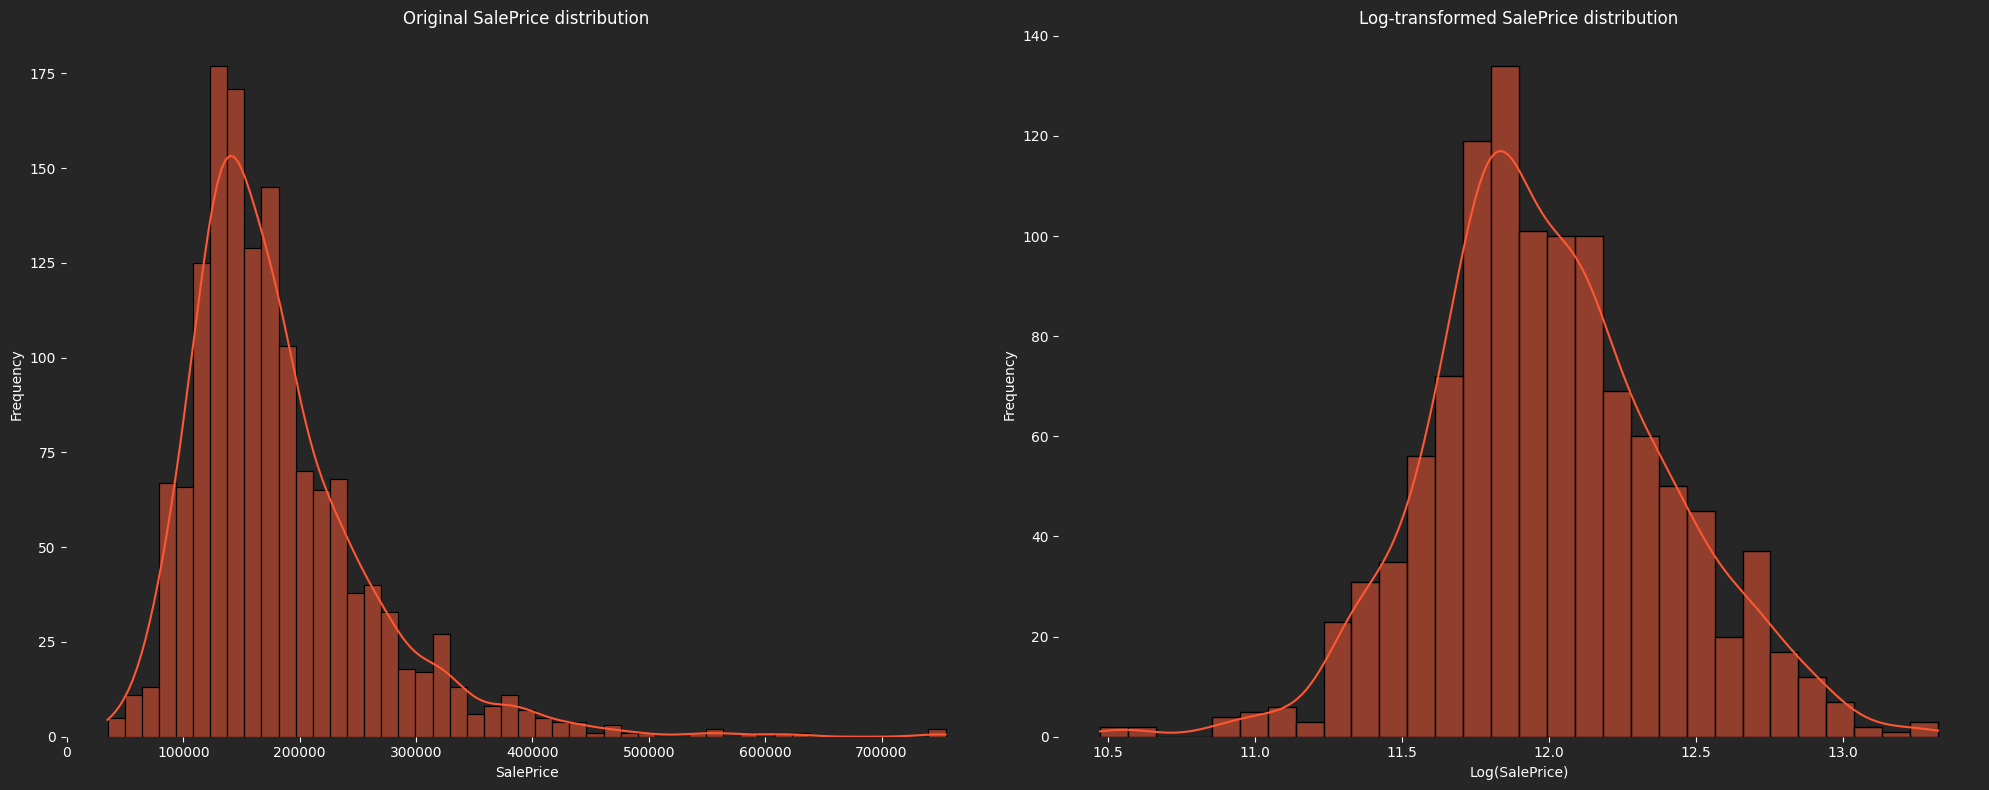

In [423]:
# Set up the figure with specified background color
fig, axes = plt.subplots(1, 2, figsize=(20, 8), facecolor=CFG.background_color)
fig.subplots_adjust(hspace=0.4, wspace=0.4)

# Plot the original SalePrice distribution
ax_before = axes[0]
ax_before.set_facecolor(CFG.background_color)
sns.histplot(CFG.train_df['SalePrice'], kde=True, ax=ax_before, color=CFG.point_color)
ax_before.set_title("Original SalePrice distribution", color=CFG.font_color)
ax_before.set_xlabel("SalePrice", color=CFG.font_color)
ax_before.set_ylabel("Frequency", color=CFG.font_color)
ax_before.tick_params(axis='x', colors=CFG.font_color)
ax_before.tick_params(axis='y', colors=CFG.font_color)
for spine in ax_before.spines.values():
    spine.set_visible(False)

# Plot the log-transformed SalePrice distribution
ax_after = axes[1]
ax_after.set_facecolor(CFG.background_color)
sns.histplot(train_df_log_transformed['SalePrice'], kde=True, ax=ax_after, color=CFG.point_color)
ax_after.set_title("Log-transformed SalePrice distribution", color=CFG.font_color)
ax_after.set_xlabel("Log(SalePrice)", color=CFG.font_color)
ax_after.set_ylabel("Frequency", color=CFG.font_color)
ax_after.tick_params(axis='x', colors=CFG.font_color)
ax_after.tick_params(axis='y', colors=CFG.font_color)
for spine in ax_after.spines.values():
    spine.set_visible(False)

plt.tight_layout()
plt.show()

## Encoding of Columns

### Define Ordinal and Nominal Features

In [424]:
# ordinal categorical features (ordered categories)
ode_cols = ['LotShape', 'LandContour','Utilities','LandSlope',  'BsmtQual',  'BsmtFinType1',  'CentralAir',  'Functional', 'PoolQC','Fence',
           'FireplaceQu', 'GarageFinish', 'GarageQual', 'PavedDrive', 'ExterCond', 'KitchenQual', 'BsmtExposure', 'HeatingQC','ExterQual', 'BsmtCond']

# nominal categorical features (unordered categories)
ohe_cols = [col for col in train_df_log_transformed.select_dtypes(include=['object']).columns if col not in ode_cols]

num_cols = numeric_cols.drop('SalePrice')

### Encoding Pipeline

In [425]:
ode_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('ode', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
])
ohe_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])
num_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

## Building a Column Transformer

In [426]:
col_trans = ColumnTransformer(transformers=[
    ('num_p', num_pipeline, num_cols),
    ('ode_p', ode_pipeline, ode_cols),
    ('ohe_p', ohe_pipeline, ohe_cols),
    ],
    remainder='passthrough', 
    n_jobs=-1)

## Splitting Data

In [427]:
X = train_df_log_transformed.drop('SalePrice', axis=1)
y = train_df_log_transformed['SalePrice']

X_preprocessed = col_trans.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_preprocessed, y, test_size=0.2, random_state=25)

## Model Training

### RFR

In [428]:
RFR = RandomForestRegressor(random_state=13)
param_grid_RFR = {
    'max_depth': [5, 10, 15],
    'n_estimators': [100, 250, 500],
    'min_samples_split': [3, 5, 10]
}
rfr_cv = GridSearchCV(RFR, param_grid_RFR, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
rfr_cv.fit(X_train, y_train)
rfr_cv.best_params_

{'max_depth': 15, 'min_samples_split': 3, 'n_estimators': 250}

In [429]:
np.sqrt(-1 * rfr_cv.best_score_)

0.13930961084207116

In [430]:
rfr_final = RandomForestRegressor(max_depth= 15, min_samples_split=3, n_estimators= 500,random_state=13)
rfr_final.fit(X_train, y_train)

RandomForestRegressor(max_depth=15, min_samples_split=3, n_estimators=500,
                      random_state=13)

### XGBM

In [431]:
XGB = XGBRegressor(random_state=13)
param_grid_XGB = {
    'learning_rate': [0.05, 0.1, 0.2],
    'n_estimators': [300],
    'max_depth': [3],
    'min_child_weight': [1,2,3],
    'gamma': [0, 0.1, 0.2],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],}
xgb_cv = GridSearchCV(XGB, param_grid_XGB, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
xgb_cv.fit(X_train, y_train)
xgb_cv.best_params_

{'colsample_bytree': 0.8,
 'gamma': 0,
 'learning_rate': 0.05,
 'max_depth': 3,
 'min_child_weight': 3,
 'n_estimators': 300,
 'subsample': 0.9}

In [432]:
np.sqrt(-1 * xgb_cv.best_score_)

0.1251614413832757

In [433]:
xgb_final = XGBRegressor(random_state=13,colsample_bytree= 0.8,gamma= 0,learning_rate= 0.05,max_depth= 3,min_child_weight= 3,n_estimators=300,subsample= 0.8)
xgb_final.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=3, missing=nan, monotone_constraints=None,
             n_estimators=300, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=13, ...)

### Ridge

In [434]:
ridge = Ridge()

param_grid_ridge = {
    'alpha': [0.05, 0.1, 1, 3, 5, 10],
    'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag']
}
ridge_cv = GridSearchCV(ridge, param_grid_ridge, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
ridge_cv.fit(X_train, y_train)
print(np.sqrt(-1 * ridge_cv.best_score_))
ridge_cv.best_params_

0.12230859669340614


{'alpha': 10, 'solver': 'auto'}

In [435]:
np.sqrt(-1 * ridge_cv.best_score_)

0.12230859669340614

In [436]:
ridge_final=Ridge(alpha=10, solver= 'sag')
ridge_final.fit(X_train, y_train)

d:\OneDrive\Documentos\PROGRAMAÇÃO\COMPETITIONS\2410-HOUSING_PRICES\house_prices\venv\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Ridge(alpha=10, solver='sag')

### LGBM

In [437]:
lgbm_regressor = lgb.LGBMRegressor()
param_grid_lgbm = {
    'boosting_type': ['gbdt', 'dart'],
    'num_leaves': [20, 30, 40],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 200, 300],
    'verbosity': [-1]
}
lgbm_cv = GridSearchCV(lgbm_regressor, param_grid_lgbm, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
lgbm_cv.fit(X_train, y_train)
lgbm_cv.best_params_

{'boosting_type': 'gbdt',
 'learning_rate': 0.05,
 'n_estimators': 200,
 'num_leaves': 20,
 'verbosity': -1}

In [438]:
np.sqrt(-1 * lgbm_cv.best_score_)

0.1343818709486341

In [439]:
lgbm_final = lgb.LGBMRegressor(boosting_type= 'gbdt',learning_rate= 0.05,n_estimators= 200,num_leaves=20)
lgbm_final.fit(X_train, y_train)

LGBMRegressor(learning_rate=0.05, n_estimators=200, num_leaves=20)

### CatBoost

In [440]:
catboost = CatBoostRegressor(loss_function='RMSE', verbose=False)
param_grid_cat ={
    'iterations': [100, 500, 1000],
    'depth': [5, 7, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.5]
}
cat_cv = GridSearchCV(catboost, param_grid_cat, cv=2, scoring='neg_mean_squared_error', n_jobs=-1)
cat_cv.fit(X_train, y_train)
cat_cv.best_params_

{'depth': 5, 'iterations': 500, 'learning_rate': 0.05}

In [441]:
np.sqrt(-1 * cat_cv.best_score_)

0.12601117865598024

In [442]:
catboost_final=CatBoostRegressor(loss_function='RMSE', verbose=False,depth=5,iterations= 500, learning_rate= 0.05)
catboost_final.fit(X_train, y_train)

## Voting and Stacking

In [443]:
vr = VotingRegressor([('rfr', rfr_final),
                      ('xgb', xgb_final),
                      ('ridge', ridge_final),
                      ('lgbm',lgbm_final),
                      ('cat',catboost_final)],
                    weights=[1,1,1,1,1])
vr.fit(X_train, y_train)

d:\OneDrive\Documentos\PROGRAMAÇÃO\COMPETITIONS\2410-HOUSING_PRICES\house_prices\venv\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


VotingRegressor(estimators=[('rfr',
                             RandomForestRegressor(max_depth=15,
                                                   min_samples_split=3,
                                                   n_estimators=500,
                                                   random_state=13)),
                            ('xgb',
                             XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=0.8,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=0...
                                          max_leaves=None, min_child_weight=3,
                                          missing=nan,
                                          monotone_constraints=None,
                                          n_estimators=300, n_jobs=None,
                                          num_parallel_tree=None,
                                          predictor=None, random_state=13, ...)),
                            ('ridge', Ridge(alpha=10, solver='sag')),
                            ('lgbm',
                             LGBMRegressor(learning_rate=0.05, n_estimators=200,
                                           num_leaves=20)),
                            ('cat',
                             <catboost.core.CatBoostRegressor object at 0x000001B626B380A0>)],
                weights=[1, 1, 1, 1, 1])

In [444]:
y_pred_vr = vr.predict(X_test)
mean_squared_error(y_test, y_pred_vr, squared=False)

0.10091805214735346

In [445]:
estimators = [
    
    ('xgb', xgb_final),
    ('cat', catboost_final),
    ('lgb', lgbm_final),
    ('rfr', rfr_final),
    ('ridge', ridge_final)

]
stackreg = StackingRegressor(
            estimators = estimators,
    final_estimator= vr
   
)
stackreg.fit(X_train, y_train)

d:\OneDrive\Documentos\PROGRAMAÇÃO\COMPETITIONS\2410-HOUSING_PRICES\house_prices\venv\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
d:\OneDrive\Documentos\PROGRAMAÇÃO\COMPETITIONS\2410-HOUSING_PRICES\house_prices\venv\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
d:\OneDrive\Documentos\PROGRAMAÇÃO\COMPETITIONS\2410-HOUSING_PRICES\house_prices\venv\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
d:\OneDrive\Documentos\PROGRAMAÇÃO\COMPETITIONS\2410-HOUSING_PRICES\house_prices\venv\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
d:\OneDrive\Documentos\PROGRAMAÇÃO\COMPETITI

StackingRegressor(estimators=[('xgb',
                               XGBRegressor(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=0.8,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None, gamma=0,
                                            gpu_id=None, grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=0...
                                                                            max_leaves=None,
                                                                            min_child_weight=3,
                                                                            missing=nan,
                                                                            monotone_constraints=None,
                                                                            n_estimators=300,
                                                                            n_jobs=None,
                                                                            num_parallel_tree=None,
                                                                            predictor=None,
                                                                            random_state=13, ...)),
                                                              ('ridge',
                                                               Ridge(alpha=10,
                                                                     solver='sag')),
                                                              ('lgbm',
                                                               LGBMRegressor(learning_rate=0.05,
                                                                             n_estimators=200,
                                                                             num_leaves=20)),
                                                              ('cat',
                                                               <catboost.core.CatBoostRegressor object at 0x000001B626B380A0>)],
                                                  weights=[1, 1, 1, 1, 1]))

In [446]:
y_pred_stack = stackreg.predict(X_test)
mean_squared_error(y_test, y_pred_stack, squared=False)

0.10254781642316887

## Creating submission.csv

In [447]:
df_test_preprocess = col_trans.transform(test_df_features)
y_stacking = np.exp(stackreg.predict(df_test_preprocess))

df_y_stacking_out = test_df_features[['Id']]
df_y_stacking_out['SalePrice'] = y_stacking

df_y_stacking_out.to_csv('submission.csv', index=False)

C:\Users\Dell\AppData\Local\Temp\ipykernel_29148\357058911.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_y_stacking_out['SalePrice'] = y_stacking
